In [1]:
# basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# pipeline
from sklearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# imbalancead learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

# classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### in this situation 2 models were tested: RandomForestClassifier and XGBoost, with 4 different resampling strategies: class_weight hyperparameter, RandomeUnderSampler, RandomOverSampler and SMOTE with TomekLinks.

In [2]:
# load dataset
df = pd.read_csv('../files/creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# check balance
df['Class'].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [4]:
# check balance
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

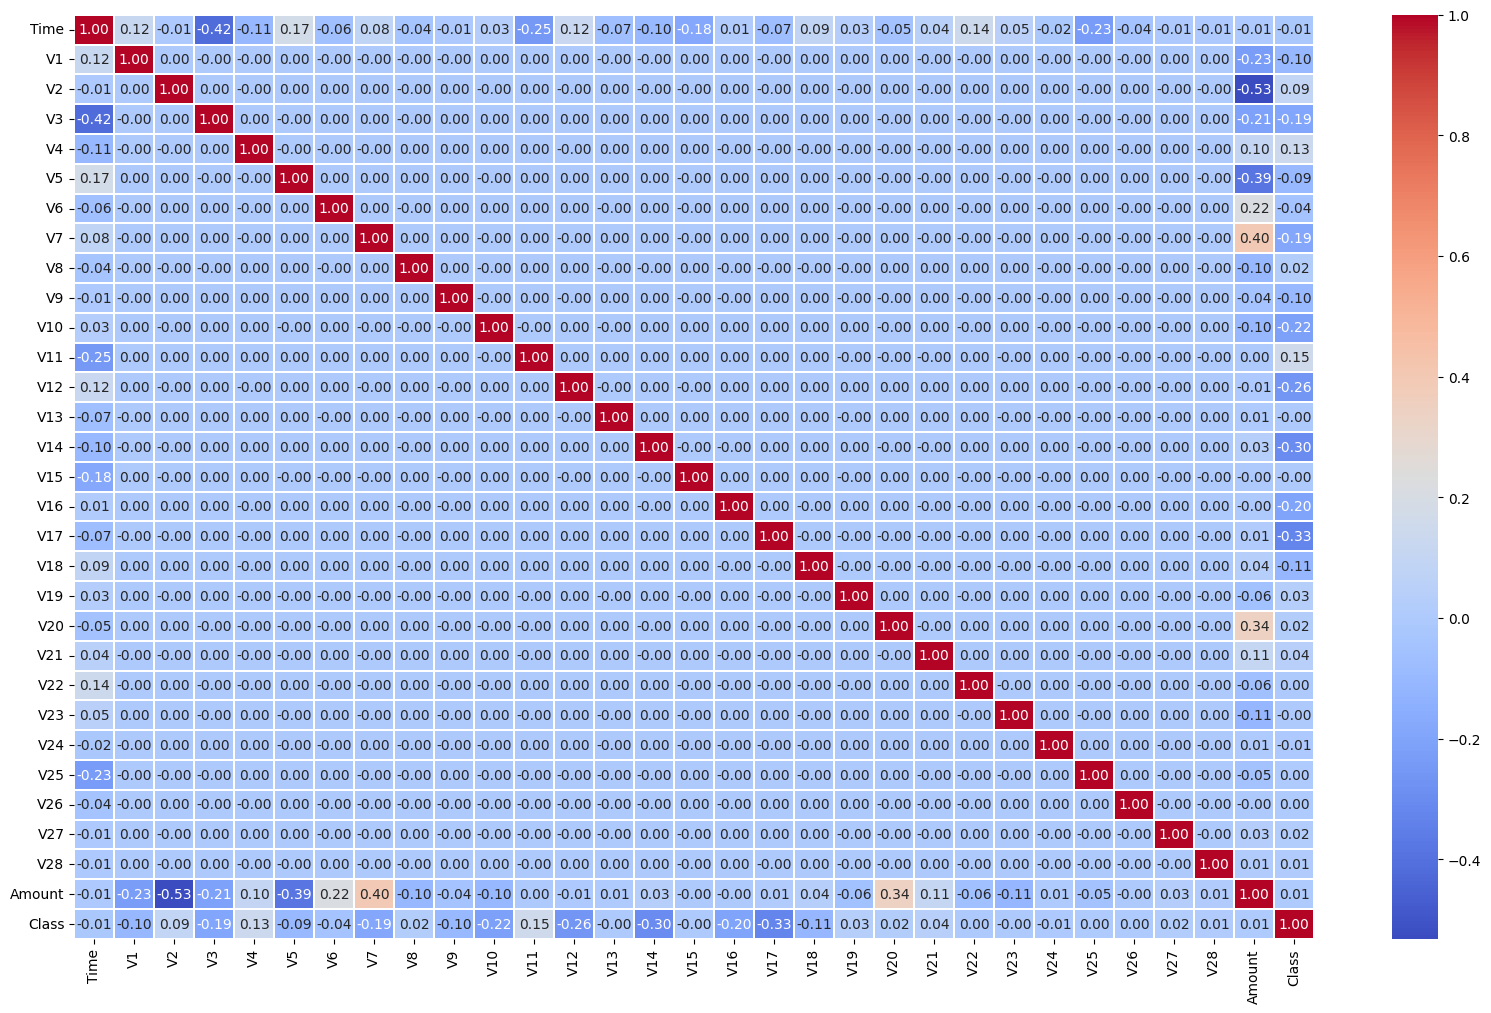

In [5]:
# correlations
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(method='pearson'),linewidths=.1,cmap='coolwarm', annot=True, fmt='.2f')
plt.yticks(rotation=0)
plt.show()

In [6]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

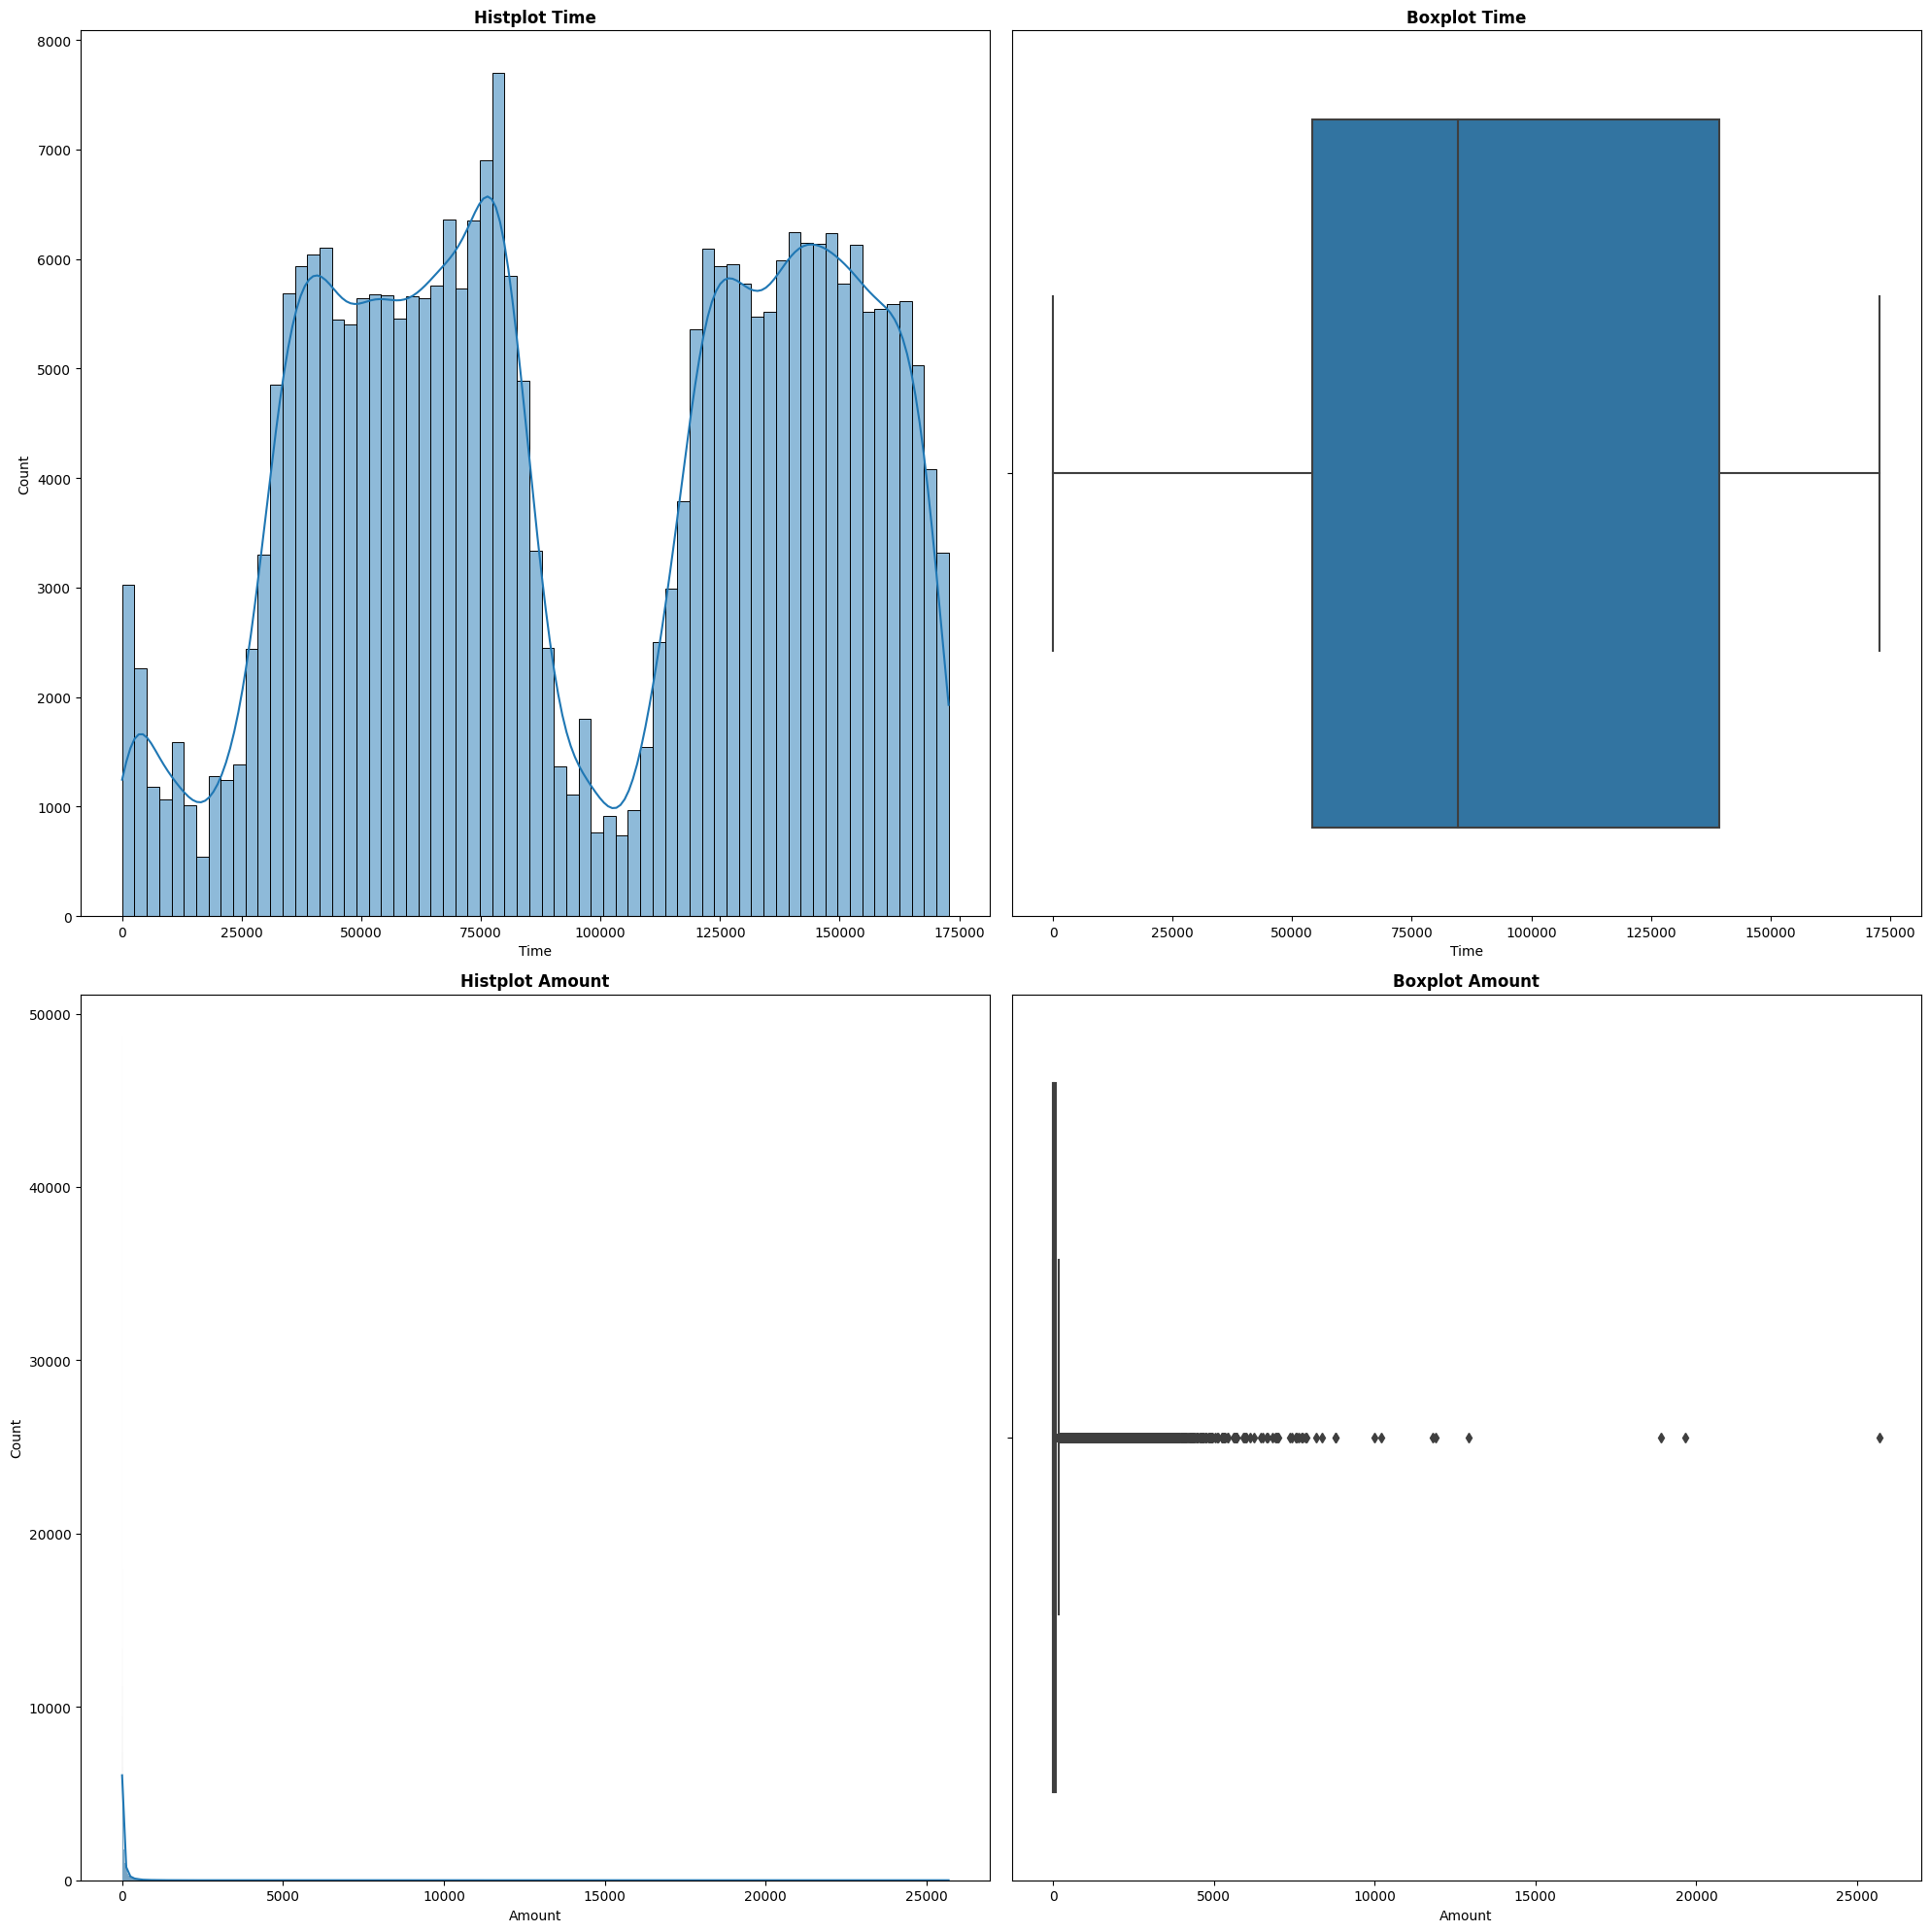

In [7]:
features = ['Time', 'Amount']
fig, ax = plt.subplots(nrows=len(features), ncols=2, figsize=(20,20))

for i, feature in enumerate(features):
    ax[i][0] = sns.histplot(x=df[feature], ax=ax[i][0], kde=True)
    ax[i][0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[i][1] = sns.boxplot(x=df[feature], ax=ax[i][1])
    ax[i][1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

In [8]:
# X and y
X = df.drop(['Time', 'Class'], axis=1).copy()
y = df['Class'].copy()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# KFolds definition
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# preprocessor
to_scalar = ['Amount']
preprocessor = ColumnTransformer(transformers=[('scalar',
                                                Pipeline(steps=[('scalar', StandardScaler())]),
                                                to_scalar
                                                )
                                               ],
                                 remainder='passthrough'
                                )

# report function
def report(X, y, model, df_model):
    """
    in: X_test, y_test, model, df_model
    out: print a best_params_, train_score, test_score, clasification_report and plot the confusion_matrix
    """

    print(f'best_params_: {model.best_params_}')
    train_score = float(df_model.loc[df_model['rank_test_score'] == 1, 'mean_train_score'])
    print(f'Train_score: {train_score}')
    print(f'Test_score_: {model.best_score_}')

    y_test_hat = model.best_estimator_.predict(X_test)
    clasification_report = classification_report(y_test, y_test_hat)
    print(clasification_report)

    confusion = confusion_matrix(y_test, y_test_hat)
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

# RandomForest

## With class_weight

best_params_: {'rfc__n_estimators': 120, 'rfc__min_samples_split': 94, 'rfc__max_depth': 7, 'rfc__criterion': 'gini'}
Train_score: 0.9996855721797505
Test_score_: 0.984226703000906
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.87      0.69        98

    accuracy                           1.00     56962
   macro avg       0.78      0.93      0.84     56962
weighted avg       1.00      1.00      1.00     56962



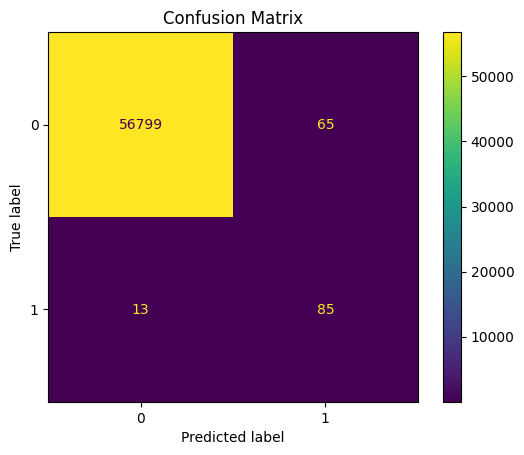

In [9]:
# RandomizedSearchCV RFC with balanced class_weight

pipe_rfc_cw = imbpipeline([('preprocessing', preprocessor),
                            ('rfc', RandomForestClassifier(n_jobs=-1, class_weight='balanced',  random_state=42))
                            ])

param_grid = {
            'rfc__n_estimators': [x for x in range(95, 130, 5)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(3, 16, 2)],
            'rfc__min_samples_split': [x for x in range(80, 95, 2)]
            }

grid_rfc_cw = RandomizedSearchCV(estimator=pipe_rfc_cw,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                error_score='raise'
                                )

grid_rfc_cw.fit(X_train, y_train)

df_imbrfc_cw = pd.DataFrame(grid_rfc_cw.cv_results_)

# report
report(X_test, y_test, grid_rfc_cw, df_imbrfc_cw)

## With RandomUnderSampler

best_params_: {'rfc__n_estimators': 110, 'rfc__min_samples_split': 84, 'rfc__max_depth': 11, 'rfc__criterion': 'entropy'}
Train_score: 0.9893532192755451
Test_score_: 0.9788917298436243
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.89      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



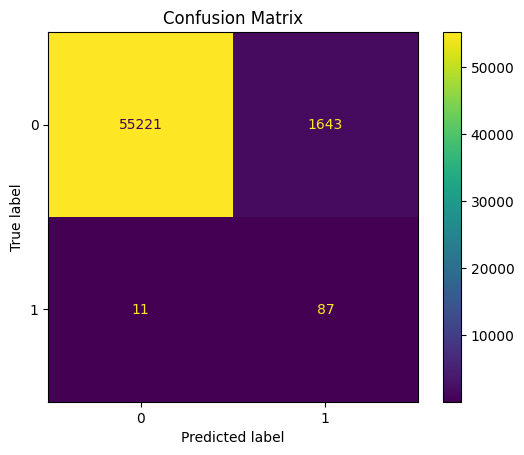

In [10]:
# RandomizedSearchCV RFC with RandomUnderSampler

pipe_rfc_rus = imbpipeline([('preprocessing', preprocessor),
                            ('rus', RandomUnderSampler(random_state=42)),
                            ('rfc', RandomForestClassifier(n_jobs=-1, class_weight=None,  random_state=42))
                            ])

param_grid = {
            'rfc__n_estimators': [x for x in range(95, 130, 5)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(3, 16, 2)],
            'rfc__min_samples_split': [x for x in range(80, 95, 2)]
            }

grid_rfc_rus = RandomizedSearchCV(estimator=pipe_rfc_rus,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                error_score='raise'
                                )

grid_rfc_rus.fit(X_train, y_train)

df_imbrfc_rus = pd.DataFrame(grid_rfc_rus.cv_results_)

# report
report(X_test, y_test, grid_rfc_rus, df_imbrfc_rus)

## With RandomOverSampler

best_params_: {'rfc__n_estimators': 110, 'rfc__min_samples_split': 94, 'rfc__max_depth': 7, 'rfc__criterion': 'entropy'}
Train_score: 0.9998135322121229
Test_score_: 0.9841161160049223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.88      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962



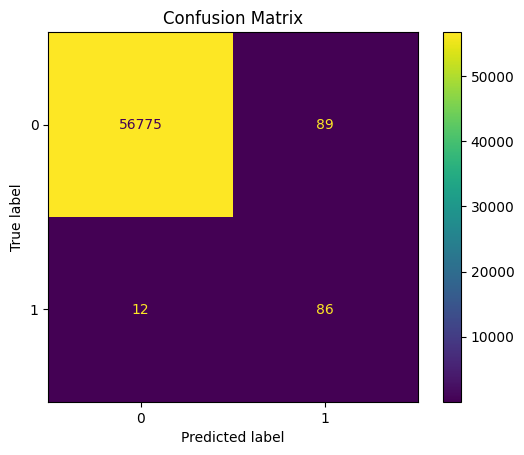

In [11]:
# RandomizedSearchCV RFC with RandomOverSampler

pipe_rfc_ros = imbpipeline([('preprocessing', preprocessor),
                            ('ros', RandomOverSampler(random_state=42)),
                            ('rfc', RandomForestClassifier(n_jobs=-1, class_weight=None,  random_state=42))
                            ])

param_grid = {
            'rfc__n_estimators': [x for x in range(95, 130, 5)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(3, 16, 2)],
            'rfc__min_samples_split': [x for x in range(80, 95, 2)]
            }

grid_rfc_ros = RandomizedSearchCV(estimator=pipe_rfc_ros,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                error_score='raise'
                                )

grid_rfc_ros.fit(X_train, y_train)

df_imbrfc_ros = pd.DataFrame(grid_rfc_ros.cv_results_)

# report
report(X_test, y_test, grid_rfc_ros, df_imbrfc_ros)

# With SMOTETomek

best_params_: {'rfc__n_estimators': 115, 'rfc__min_samples_split': 87, 'rfc__max_depth': 9, 'rfc__criterion': 'gini'}
Train_score: 0.9997347345151345
Test_score_: 0.9851613795023886
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.88      0.53        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.76     56962
weighted avg       1.00      1.00      1.00     56962



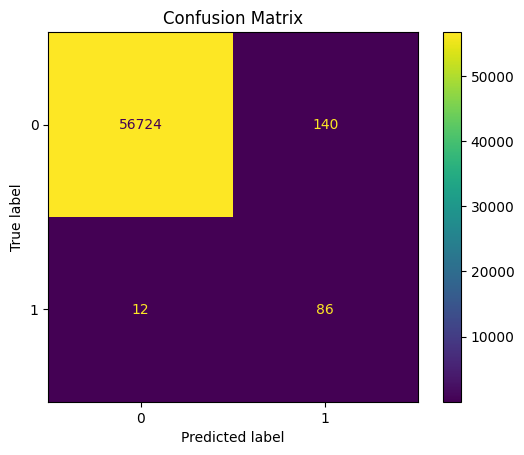

In [12]:
# RandomizedSearchCV RFC with SMOTETomek

tomeklinks = TomekLinks(sampling_strategy='not minority', n_jobs=-1)
pipe_rfc_smt = imbpipeline([('preprocessing', preprocessor),
                            ('smt', SMOTETomek(sampling_strategy='minority', tomek=tomeklinks, n_jobs=-1, random_state=42)),
                            ('rfc', RandomForestClassifier(n_jobs=-1, class_weight=None,  random_state=42))
                            ])

param_grid = {
            'rfc__n_estimators': [x for x in range(95, 125, 5)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(3, 12, 2)],
            'rfc__min_samples_split': [x for x in range(85, 95, 2)]
            }

grid_rfc_smt = RandomizedSearchCV(estimator=pipe_rfc_smt,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                error_score='raise'
                                )

grid_rfc_smt.fit(X_train, y_train)

df_imbrfc_smt = pd.DataFrame(grid_rfc_smt.cv_results_)

# report
report(X_test, y_test, grid_rfc_smt, df_imbrfc_smt)

# XGBoost

##  With RandomUnderSampler

c:\Users\fer\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best_params_: {'xgb__reg_alpha': 0.001, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0}
Train_score: 0.9989488222247559
Test_score_: 0.9800423975401715
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962



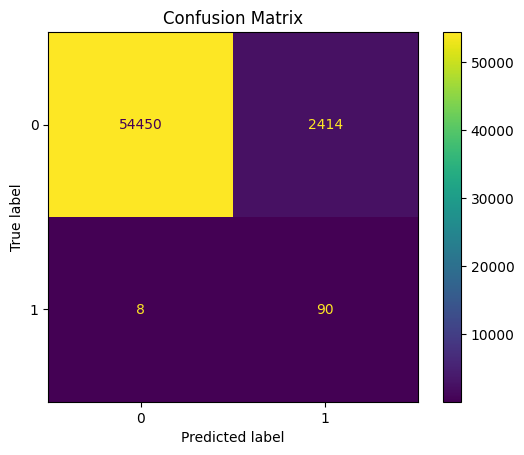

In [13]:
# RandomizedSearchCV XGB with RandomUnderSampler

pipe_xgb_rus = imbpipeline([('preprocessing', preprocessor),
                            ('rus', RandomUnderSampler(random_state=42)),
                            ('xgb', XGBClassifier(n_jobs=-1, tree_method='gpu_hist', random_state=42))
                            ])

param_grid = {
            'xgb__learning_rate': [0.001, 0.01, 0.2, 0.3, 0.4],
            'xgb__gamma': [0, 0.001, 0.01, 0.1],
            'xgb__max_depth': [x for x in range(3, 6, 1)],
            'xgb__reg_alpha': [0.001, 0.01, 0.1, 0.3, 0.5]
            }

grid_xgb_rus = RandomizedSearchCV(estimator=pipe_xgb_rus,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True
                                )

grid_xgb_rus.fit(X_train, y_train)

df_xgb_rus = pd.DataFrame(grid_xgb_rus.cv_results_)

# report
report(X_test, y_test, grid_xgb_rus, df_xgb_rus)

## With RandomOverSampler

c:\Users\fer\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best_params_: {'xgb__reg_alpha': 0.01, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.1}
Train_score: 0.9999936212335971
Test_score_: 0.9793697094232373
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.86      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962



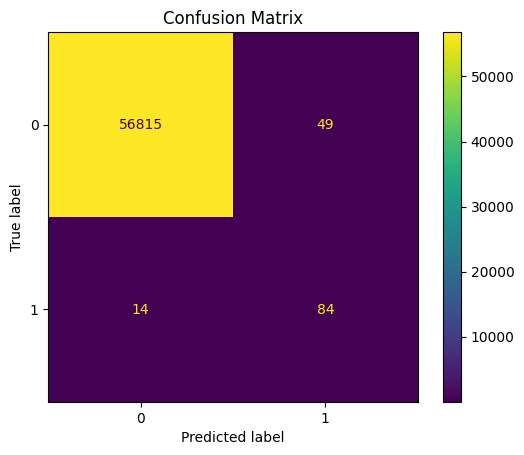

In [14]:
# RandomizedSearchCV XGB with RandomOverSampler

pipe_xgb_ros = imbpipeline([('preprocessing', preprocessor),
                            ('ros', RandomOverSampler(random_state=42)),
                            ('xgb', XGBClassifier(n_jobs=-1, tree_method='gpu_hist', random_state=42))
                            ])

param_grid = {
            'xgb__learning_rate': [0.001, 0.01, 0.2, 0.3],
            'xgb__gamma': [0, 0.001, 0.01, 0.1],
            'xgb__max_depth': [x for x in range(3, 6, 1)],
            'xgb__reg_alpha': [0.001, 0.01, 0.1, 0.2]
            }

grid_xgb_ros = RandomizedSearchCV(estimator=pipe_xgb_ros,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True
                                )

grid_xgb_ros.fit(X_train, y_train)

df_xgb_ros = pd.DataFrame(grid_xgb_ros.cv_results_)

# report
report(X_test, y_test, grid_xgb_ros, df_xgb_ros)

## With SMOTETomek

best_params_: {'xgb__reg_alpha': 0.001, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1}
Train_score: 0.9883641057053282
Test_score_: 0.9808187328924799
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



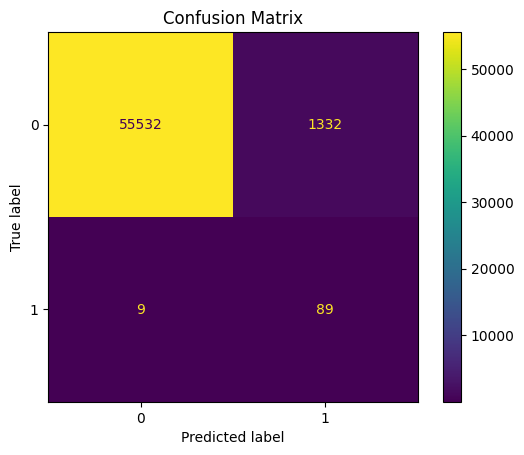

In [15]:
# RandomizedSearchCV XGB with SMOTETomek

tomeklinks = TomekLinks(sampling_strategy='not minority', n_jobs=-1)

pipe_xgb_smt = imbpipeline([('preprocessing', preprocessor),
                            ('smt', SMOTETomek(sampling_strategy='minority', tomek=tomeklinks, n_jobs=-1, random_state=42)),
                            ('xgb', XGBClassifier(n_jobs=-1, tree_method='gpu_hist', random_state=42))
                            ])

param_grid = {
            'xgb__learning_rate': [0.001, 0.01, 0.2],
            'xgb__gamma': [0, 0.001, 0.01, 0.1],
            'xgb__max_depth': [x for x in range(2, 5, 1)],
            'xgb__reg_alpha': [0.001, 0.01, 0.1, 0.2]
            }

grid_xgb_smt = RandomizedSearchCV(estimator=pipe_xgb_smt,
                                param_distributions=param_grid,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True
                                )

grid_xgb_smt.fit(X_train, y_train)

df_xgb_smt = pd.DataFrame(grid_xgb_smt.cv_results_)

# report
report(X_test, y_test, grid_xgb_smt,df_xgb_smt)

## StackingClassifier

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

estimator_list = [
    ('rfc', grid_rfc_cw.best_estimator_),
    ('svc', grid_xgb_smt.best_estimator_)
    ]

stack_model = StackingClassifier(estimators=estimator_list,
                                 final_estimator=LogisticRegression(
                                     penalty='l2',
                                     solver='lbfgs',
                                     max_iter=200,
                                     C=0.1,
                                     class_weight='balanced',
                                     n_jobs=-1,
                                     random_state=42),
                                 n_jobs=-1
                                 )

stack_model.fit(X_train, y_train)

y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

stack_model_train_accuracy = accuracy_score(y_train, y_train_pred)

stack_model_test_accuracy = accuracy_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)

print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)

Model performance for Training set
- Accuracy: 0.977778753099695
Model performance for Test set
- Accuracy: 0.9765106562269583


In [20]:
# classification report stack_model
y_test_pred_stack_model = stack_model.predict(X_test)
cr_stack_model = classification_report(y_test, y_test_pred_stack_model)
print(cr_stack_model)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



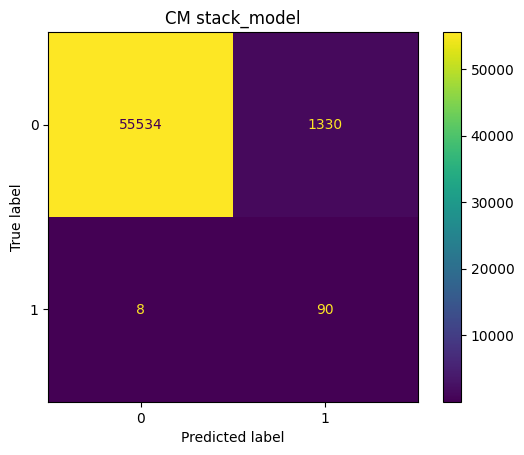

In [21]:
# stack_model confusion matrix
cm_stack_model = confusion_matrix(y_test, y_test_pred_stack_model)
disp_stack_model = ConfusionMatrixDisplay(cm_stack_model)
disp_stack_model.plot()
plt.title('CM stack_model')
plt.show()

## ploting models performance

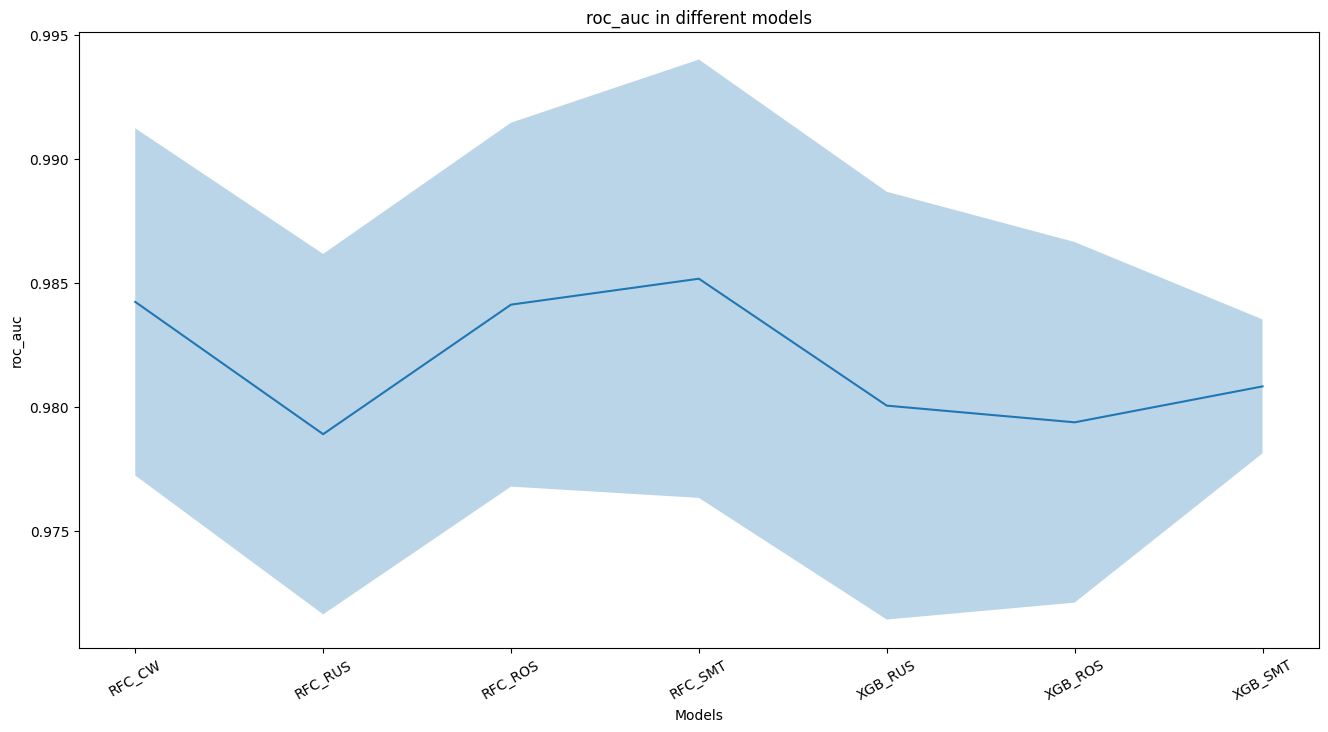

In [22]:
list_models = [df_imbrfc_cw, df_imbrfc_rus, df_imbrfc_ros, df_imbrfc_smt, df_xgb_rus, df_xgb_ros, df_xgb_smt]
list_models_names = ['RFC_CW', 'RFC_RUS', 'RFC_ROS', 'RFC_SMT', 'XGB_RUS', 'XGB_ROS', 'XGB_SMT']

list_mean = []
list_3std = []

for model in list_models:
    list_mean.append(model.loc[model['rank_test_score'] == 1]['mean_test_score'].values[0])
    list_3std.append(model.loc[model['rank_test_score'] == 1]['std_test_score'].values[0])

models = pd.DataFrame({'model': list_models_names, 'mean_test_score': list_mean, 'std_test_score': list_3std})

# plot
plt.figure(figsize=(16, 8))

sns.lineplot(x=models['model'].values,
             y=models['mean_test_score'].values)

plt.fill_between(x=models['model'],
                 y1=models['mean_test_score'] + models['std_test_score'],
                 y2=models['mean_test_score'] - models['std_test_score'],
                 alpha=0.3)

plt.xticks(list(models['model'].values), rotation=30)
plt.title('roc_auc in different models')
plt.ylabel('roc_auc')
plt.xlabel('Models')
plt.show()